# Set up

In [1]:
%%time
%config Completer.use_jedi = False
#!/usr/bin/env python3
import wmfdata as wmf
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

You are using Wmfdata v2.0.0, but v2.0.1 is available.

To update, run `pip install --upgrade git+https://github.com/wikimedia/wmfdata-python.git@release`.

To see the changes, refer to https://github.com/wikimedia/wmfdata-python/blob/release/CHANGELOG.md.


CPU times: user 1.83 s, sys: 1.62 s, total: 3.45 s
Wall time: 1.54 s


In [2]:
%%time
df_projects_language = pd.read_csv('../data/projects_to_language.csv').sort_values(['wiki_db'])
#df_projects_language = df_projects_language[df_projects_language.type=='wiki']
df_projects_language_dict = dict(zip(df_projects_language.wiki_db, df_projects_language.project))
wikis = list(df_projects_language_dict.keys())
wikis.remove('labtestwiki')
wikis.remove('metawiki')

CPU times: user 8.68 ms, sys: 474 µs, total: 9.16 ms
Wall time: 7.11 ms


# Retrieve and parse rights logs

In [3]:
%%time
query = """SELECT log_timestamp, log_type, log_title, log_params, IF(comment_text LIKE '%+%' OR comment_text LIKE '%=%', comment_text,'') as comment_text
            FROM logging l JOIN comment c
            ON l.log_comment_id=c.comment_id
            WHERE log_type='rights' AND log_action='rights' AND (log_params LIKE '%sysop%' OR comment_text LIKE '%sysop%')
            """
# metawiki logs affecting other wikis
logging_rights = wmf.mariadb.run(query,'metawiki')
logging_rights = logging_rights[(logging_rights.log_title.str.contains('@'))&(logging_rights.log_title.str.endswith('wiki'))]
logging_rights['wiki_db'] =  logging_rights['log_title'].str.split('@').str[1]
logging_rights['log_title'] =  logging_rights['log_title'].str.split('@').str[0]

# other wikis logs
for wiki_db in wikis:
    print (wiki_db, end=' ')        
    logging_rights_wiki = wmf.mariadb.run(query,wiki_db)
    logging_rights_wiki['wiki_db'] = wiki_db
    logging_rights = pd.concat([logging_rights,logging_rights_wiki])

logging_rights = logging_rights.sort_values(['wiki_db','log_timestamp'])
logging_rights

aawiki aawikibooks aawiktionary abwiki abwiktionary acewiki advisorswiki advisorywiki adywiki afwiki afwikibooks afwikiquote afwiktionary akwiki akwikibooks akwiktionary alswiki amwiki amwikimedia amwikiquote amwiktionary angwiki angwikibooks angwikiquote angwikisource angwiktionary anwiki anwiktionary arbcom_cswiki arbcom_dewiki arbcom_enwiki arbcom_fiwiki arbcom_nlwiki arcwiki arwiki arwikibooks arwikimedia arwikinews arwikiquote arwikisource arwikiversity arwiktionary arzwiki astwiki astwikibooks astwikiquote astwiktionary aswiki aswikibooks aswikisource aswiktionary atjwiki auditcomwiki avwiki avwiktionary aywiki aywikibooks aywiktionary azbwiki azwiki azwikibooks azwikiquote azwikisource azwiktionary banwiki barwiki bat_smgwiki bawiki bawikibooks bclwiki bdwikimedia be_x_oldwiki betawikiversity bewiki bewikibooks bewikimedia bewikiquote bewikisource bewiktionary bgwiki bgwikibooks bgwikinews bgwikiquote bgwikisource bgwiktionary bhwiki bhwiktionary biwiki biwikibooks biwiktionary 

log_timestamp log_type      log_title  \
24570  20140825060054   rights  Ko.S.ystem.OV   
63     20050205154809   rights         Angela   
214    20050408073304   rights   Andre_Engels   
397    20050709082928   rights   Tim_Starling   
844    20051112195711   rights         Angela   
...               ...      ...            ...   
17842  20110405062901   rights         Jusjih   
31576  20200923144842   rights     3atbulletz   
31871  20201228103034   rights     3atbulletz   
32218  20210311102552   rights  SmangaMbongwa   
32447  20210630010920   rights     3atbulletz   

                                              log_params  \
24570  a:2:{s:12:"4::oldgroups";a:1:{i:0;s:5:"sysop";...   
63                                                         
214                                                        
397                                                        
844                                              \nsysop   
...                                                  ...   
17842                                            sysop\n   
31576  a:4:{s:12:"4::oldgroups";a:0:{}s:12:"5::newgro...   
31871  a:4:{s:12:"4::oldgroups";a:0:{}s:12:"5::newgro...   
32218  a:4:{s:12:"4::oldgroups";a:0:{}s:12:"5::newgro...   
32447  a:4:{s:12:"4::oldgroups";a:0:{}s:12:"5::newgro...   

                                            comment_text wiki_db  
24570                                                             
63                                      =sysop,developer  aawiki  
214                                               =sysop  aawiki  
397                                   +bureaucrat +sysop  aawiki  
844                                                       aawiki  
...                                                  ...     ...  
17842                                                     zuwiki  
31576  per [[m:Special:Permalink/20473452|request]], ...  zuwiki  
31871                                                     zuwiki  
32218                                                     zuwiki  
32447                                                     zuwiki  

[71295 rows x 6 columns]

In [4]:
def is_active_sysop(log_title, sysops):
    try:
        return (np.isnan(sysops[sysops.log_title==log_title].tail(1).end_timestamp.values[0]))
    except:
        return False

In [5]:
%%time
admins = pd.DataFrame(columns=['wiki_db', 'user_name', 'start_timestamp', 'end_timestamp'])

for wiki_db in wikis:

    print (wiki_db)        
    logging_rights_wiki = logging_rights[logging_rights.wiki_db==wiki_db]
    
    for index, row in logging_rights_wiki.iterrows():       
        if len(row.log_params):
            
            if row.log_params.startswith('a:'):    
                split = re.split('(oldgroups)|(newgroups)|(oldmetada)|(newmetadata)', row.log_params)
                oldgroups = [r.replace('"','') for r in re.findall('"[a-z]+"',split[5])]
                newgroups = [r.replace('"','') for r in re.findall('"[a-z]+"',split[10])]
                if len(split)>20:
                    expiry = re.search('[0-9]{14}',split[20])
                    if expiry: expiry=expiry.group()
                    else: expiry=np.nan
            else:
                split = row.log_params.split('\n')
                oldgroups, newgroups = split[0], split[1]
                expiry = np.nan
                
            if 'sysop' in newgroups and not 'sysop' in oldgroups and not is_active_sysop(row.log_title, admins):
                admins = admins.append(({
                    'wiki_db': wiki_db,
                    'user_name': row.log_title,
                    'start_timestamp': row.log_timestamp,
                    'end_timestamp': expiry
                }), ignore_index=True)
            elif 'sysop' in oldgroups and not 'sysop' in newgroups:
                try:
                    admins.at[admins[admins.user_name==row.log_title].tail(1).index[0], 'end_timestamp'] = row.log_timestamp
                except: # error as there was no log adding this editor to sysops
                    # TO-DO: check if the editor was not found because of a previous alias
                    print('\terror! not found:', row.log_title)
                    admins = admins.append(({
                        'wiki_db': wiki_db,
                        'user_name': row.log_title,
                        'end_timestamp': row.log_timestamp}), ignore_index=True)
                    
        elif len(row.comment_text):
            if ('+sysop' in row.comment_text or '=sysop' in row.comment_text) and not is_active_sysop(row.log_title, admins):
                admins = admins.append(({
                    'wiki_db': wiki_db,
                    'user_name': row.log_title,
                    'start_timestamp': row.log_timestamp}), ignore_index=True)
admins    

aawiki
aawikibooks
aawiktionary
abwiki
abwiktionary
acewiki
	error! not found: Rachmat04
advisorswiki
advisorywiki
	error! not found: Sue_Gardner
adywiki
afwiki
	error! not found: Brion_VIBBER
	error! not found: Alias
	error! not found: TeunSpaans
	error! not found: Adriaan
	error! not found: RAM
afwikibooks
afwikiquote
afwiktionary
akwiki
	error! not found: Abuse_filter
akwikibooks
akwiktionary
alswiki
	error! not found: Transalpin
	error! not found: Melancholie
	error! not found: J._'mach'_wust
amwiki
amwikimedia
amwikiquote
amwiktionary
angwiki
	error! not found: James
angwikibooks
angwikiquote
angwikisource
angwiktionary
anwiki
anwiktionary
arbcom_cswiki
arbcom_dewiki
	error! not found: Thogo
arbcom_enwiki
	error! not found: Charles_Matthews_(retired)
	error! not found: Werdna
arbcom_fiwiki
	error! not found: Ejs-80_(kausi_2009-2011)
	error! not found: JSutherland_(WMF)
arbcom_nlwiki
	error! not found: Niels-new
arcwiki
arwiki
	error! not found: مصطفى
	error! not found: أبو_سليمان


wiki_db      user_name start_timestamp   end_timestamp
0      aawiki         Angela  20050205154809             NaN
1      aawiki   Andre_Engels  20050408073304             NaN
2      aawiki   Tim_Starling  20050709082928  20151124122813
3      aawiki         Angela  20051112195711  20051112200124
4      aawiki      Aurevilly  20060118205902  20060118210357
...       ...            ...             ...             ...
22306  zuwiki         Jusjih  20110405062745  20110405062901
22307  zuwiki     3atbulletz  20200923144842  20201223144842
22308  zuwiki     3atbulletz  20201228103034  20210628103034
22309  zuwiki  SmangaMbongwa  20210311102552  20210611102552
22310  zuwiki     3atbulletz  20210630010920  20211230010920

[22311 rows x 4 columns]

In [6]:
admins[['wiki_db','user_name','start_timestamp','end_timestamp']].to_csv('../data/admins.csv', sep=',', encoding='utf-8', index=False)

# Exploratory Data Analysis

In [7]:
admins = pd.read_csv('../data/admins.csv')
admins['start_timestamp'] = admins['start_timestamp'].astype('Int64', errors='ignore').astype('string', errors='ignore')
admins['end_timestamp'] = admins['end_timestamp'].astype('Int64', errors='ignore').astype('string', errors='ignore')
admins

wiki_db      user_name start_timestamp   end_timestamp
0      aawiki         Angela  20050205154809            <NA>
1      aawiki   Andre_Engels  20050408073304            <NA>
2      aawiki   Tim_Starling  20050709082928  20151124122813
3      aawiki         Angela  20051112195711  20051112200124
4      aawiki      Aurevilly  20060118205902  20060118210357
...       ...            ...             ...             ...
22306  zuwiki         Jusjih  20110405062745  20110405062901
22307  zuwiki     3atbulletz  20200923144842  20201223144842
22308  zuwiki     3atbulletz  20201228103034  20210628103034
22309  zuwiki  SmangaMbongwa  20210311102552  20210611102552
22310  zuwiki     3atbulletz  20210630010920  20211230010920

[22311 rows x 4 columns]

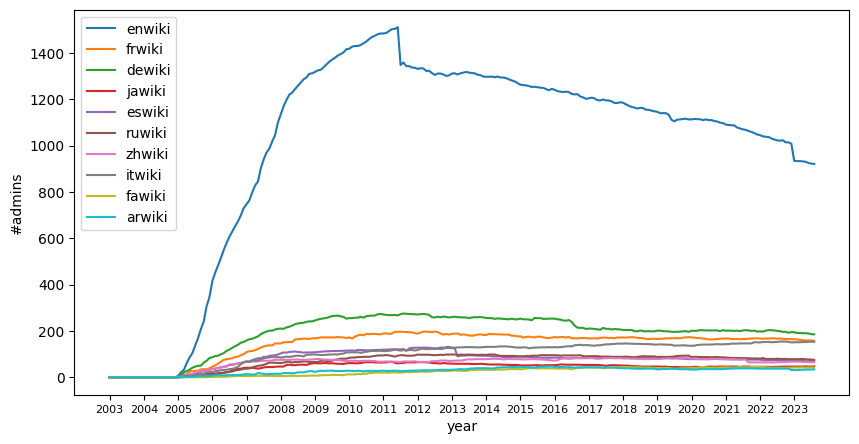

In [8]:
start_date = '2003-01'
end_date = '2023-09'
large_wikis = ['enwiki', 'frwiki', 'dewiki', 'jawiki', 'eswiki', 'ruwiki', 'zhwiki', 'itwiki', 'fawiki', 'arwiki', 'plwiki', 'nlwiki', 'ukwiki', 'trwiki', 'idwiki', 'hewiki', 'cswiki', 'svwiki', 'uzwiki', 'viwiki', 'fiwiki', 'kowiki', 'huwiki', 'cawiki', 'hiwiki', 'nowiki', 'bnwiki', 'thwiki', 'elwiki', 'rowiki', 'srwiki', 'bgwiki', 'dawiki', 'azwiki', 'mswiki', 'etwiki', 'euwiki', 'skwiki', 'hrwiki', 'hywiki', 'slwiki', 'ltwiki', 'eowiki', 'urwiki', 'tawiki', 'lvwiki', 'kawiki']
admins['start_datetime'] = admins['start_timestamp'].apply(pd.to_datetime)
admins['end_datetime'] = admins['end_timestamp'].apply(pd.to_datetime)
pr = pd.period_range(start=start_date,end=end_date, freq='M')
dates = tuple([(period.year,period.month) for period in pr])

fig = plt.figure(figsize=(10,5))
for wiki in large_wikis[:10]:
    admin_count = []
    admins_wiki = admins[admins.wiki_db==wiki]
    for i, date in enumerate(dates):
        if i+1<len(dates): 
            admin_count.append(len(admins_wiki[
                (admins_wiki.start_datetime<=datetime(date[0], date[1],1,0,0))&
                ((admins_wiki.end_datetime.isna())|(admins_wiki.end_datetime>datetime(dates[i+1][0], dates[i+1][1],1,0,0)))
            ]))
    plt.plot(range(len(admin_count)), admin_count, label=wiki)
    plt.xticks(range(0,20*12+1,12),range(2003,2024), fontsize=8)
    plt.xlabel('year')
    plt.ylabel('#admins')
plt.legend()
plt.show()

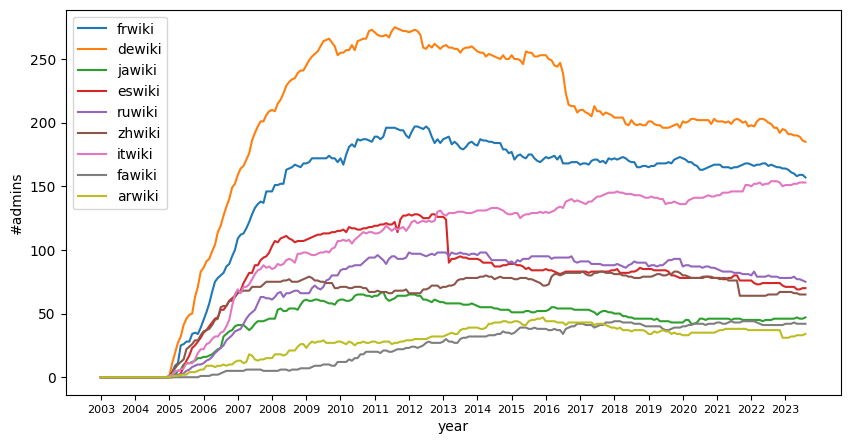

In [9]:
fig = plt.figure(figsize=(10,5))
for wiki in large_wikis[1:10]:
    admin_count = []
    admins_wiki = admins[admins.wiki_db==wiki]
    for i, date in enumerate(dates):
        if i+1<len(dates): 
            admin_count.append(len(admins_wiki[
                (admins_wiki.start_datetime<=datetime(date[0], date[1],1,0,0))&
                ((admins_wiki.end_datetime.isna())|(admins_wiki.end_datetime>datetime(dates[i+1][0], dates[i+1][1],1,0,0)))
            ]))
    plt.plot(range(len(admin_count)), admin_count, label=wiki)
    plt.xticks(range(0,20*12+1,12),range(2003,2024), fontsize=8)
    plt.xlabel('year')
    plt.ylabel('#admins')
plt.legend()
plt.show()

## enwiki

In [10]:
wiki_db ='enwiki'

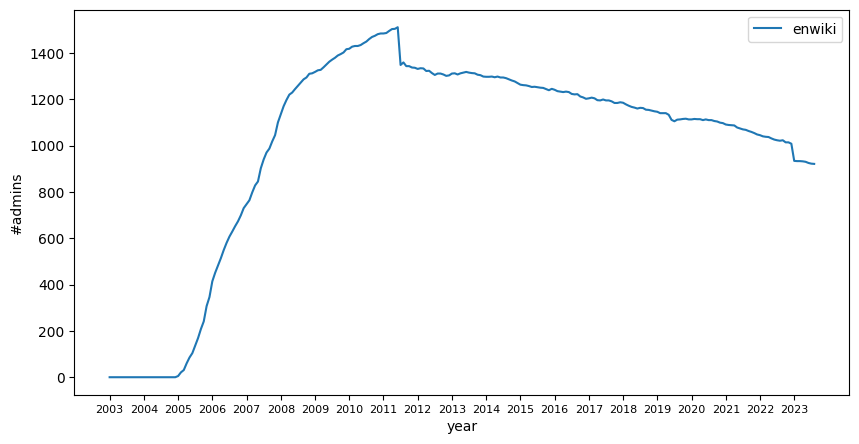

In [11]:
fig = plt.figure(figsize=(10,5))
admin_count = []
admins_wiki = admins[admins.wiki_db==wiki_db]
for i, date in enumerate(dates):
    if i+1<len(dates): 
        admin_count.append(len(admins_wiki[
            (admins_wiki.start_datetime<=datetime(date[0], date[1],1,0,0))&
            ((admins_wiki.end_datetime.isna())|(admins_wiki.end_datetime>datetime(dates[i+1][0], dates[i+1][1],1,0,0)))
        ]))
plt.plot(range(len(admin_count)), admin_count, label=wiki_db)
plt.xticks(range(0,20*12+1,12),range(2003,2024), fontsize=8)
plt.xlabel('year')
plt.ylabel('#admins')
plt.legend()
plt.show()

In [12]:
# Top days by admin drop-off
print (admins[(admins.wiki_db==wiki_db)&(admins.end_timestamp.str.startswith('2'))].end_timestamp.astype(str).replace('......$','',regex=True).value_counts().head())

20110703    247
20230101     97
20120401     21
20110909     18
20110904     18
Name: end_timestamp, dtype: int64


In [13]:
# Most common messages on admins drop-off on a specific date
specific_date = '20110703'
query = """SELECT log_timestamp, log_type, log_title, log_params, IF(comment_text LIKE '%+%' OR comment_text LIKE '%=%', comment_text,'') as comment_text
            FROM logging l JOIN comment c
            ON l.log_comment_id=c.comment_id
            WHERE log_type='rights' AND log_action='rights'
            AND (log_params LIKE '%sysop%' OR comment_text LIKE '%sysop%')
            AND log_timestamp LIKE '{specific_date}%'
            AND log_title LIKE '%@{wiki_db}'
            """.format(wiki_db=wiki_db, specific_date=specific_date)
print(wmf.mariadb.run(query,'metawiki').comment_text.value_counts())

http://meta.wikimedia.org/wiki/?diff=prev&oldid=2697150    252
                                                             6
Name: comment_text, dtype: int64


## eswiki

In [14]:
wiki_db ='eswiki'

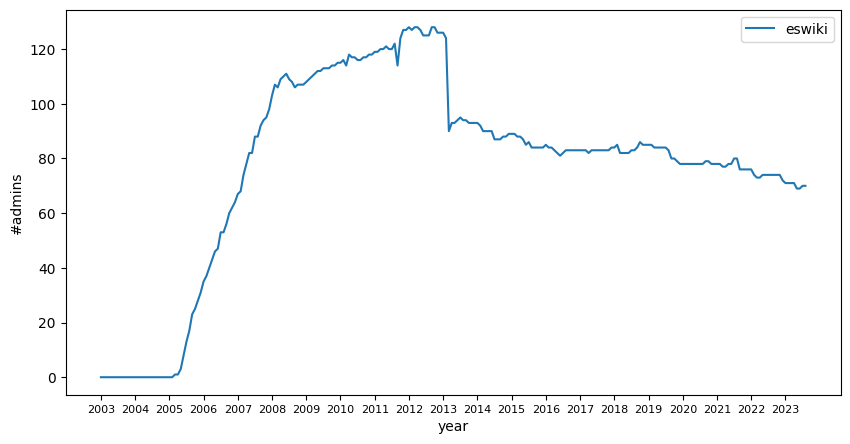

In [15]:
fig = plt.figure(figsize=(10,5))
admin_count = []
admins_wiki = admins[admins.wiki_db==wiki_db]
for i, date in enumerate(dates):
    if i+1<len(dates): 
        admin_count.append(len(admins_wiki[
            (admins_wiki.start_datetime<=datetime(date[0], date[1],1,0,0))&
            ((admins_wiki.end_datetime.isna())|(admins_wiki.end_datetime>datetime(dates[i+1][0], dates[i+1][1],1,0,0)))
        ]))
plt.plot(range(len(admin_count)), admin_count, label=wiki_db)
plt.xticks(range(0,20*12+1,12),range(2003,2024), fontsize=8)
plt.xlabel('year')
plt.ylabel('#admins')
plt.legend()
plt.show()

In [16]:
# Top days by admin drop-off
print (admins[(admins.wiki_db==wiki_db)&(admins.end_timestamp.str.startswith('2'))].end_timestamp.astype(str).replace('......$','',regex=True).value_counts().head())

20130322    46
20110924    16
20080314     2
20180317     2
20210916     2
Name: end_timestamp, dtype: int64


In [17]:
# Most common messages on admins drop-off on a specific date
specific_date = '20130322'
query = """SELECT log_timestamp, log_type, log_title, log_params, IF(comment_text LIKE '%+%' OR comment_text LIKE '%=%', comment_text,'') as comment_text
            FROM logging l JOIN comment c
            ON l.log_comment_id=c.comment_id
            WHERE log_type='rights' AND log_action='rights'
            AND (log_params LIKE '%sysop%' OR comment_text LIKE '%sysop%')
            AND log_timestamp LIKE '{specific_date}%'
            AND log_title LIKE '%@{wiki_db}'
            """.format(wiki_db=wiki_db, specific_date=specific_date)
print(wmf.mariadb.run(query,'metawiki').comment_text.value_counts())

Per request at [[SRP]] - https://meta.wikimedia.org/?oldid=5338351#Several_usernames.40eswiki - Local policy for inactive admins    31
Per request at [[SRP]] - https://meta.wikimedia.org/?oldid=5338351#Several_usernames.40eswiki - Local policy for inactive users;     8
Per request at [[SRP]] - https://meta.wikimedia.org/?oldid=5338351#Several_usernames.40eswiki - Local policy for inactive users      8
Name: comment_text, dtype: int64


## zhwiki

In [18]:
wiki_db ='zhwiki'

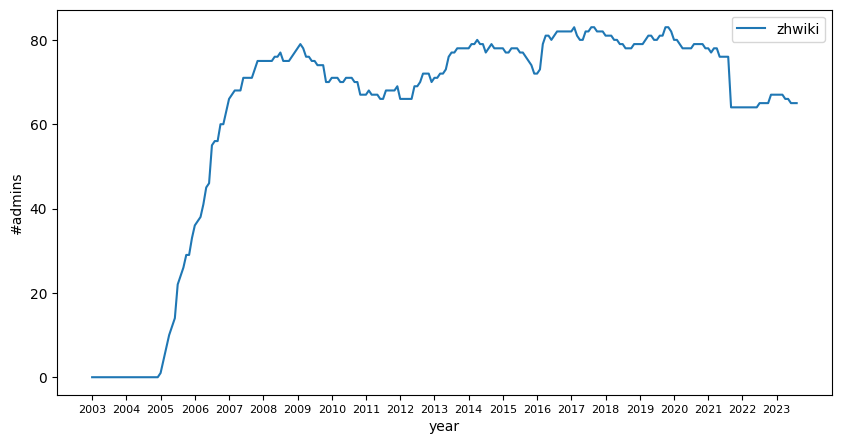

In [19]:
fig = plt.figure(figsize=(10,5))
admin_count = []
admins_wiki = admins[admins.wiki_db==wiki_db]
for i, date in enumerate(dates):
    if i+1<len(dates): 
        admin_count.append(len(admins_wiki[
            (admins_wiki.start_datetime<=datetime(date[0], date[1],1,0,0))&
            ((admins_wiki.end_datetime.isna())|(admins_wiki.end_datetime>datetime(dates[i+1][0], dates[i+1][1],1,0,0)))
        ]))
plt.plot(range(len(admin_count)), admin_count, label=wiki_db)
plt.xticks(range(0,20*12+1,12),range(2003,2024), fontsize=8)
plt.xlabel('year')
plt.ylabel('#admins')
plt.legend()
plt.show()

In [20]:
# Top days by admin drop-off
print (admins[(admins.wiki_db==wiki_db)&(admins.end_timestamp.str.startswith('2'))].end_timestamp.astype(str).replace('......$','',regex=True).value_counts().head())

20210913    11
20120111     4
20091118     4
20080826     3
20091122     3
Name: end_timestamp, dtype: int64


In [21]:
# Most common messages on admins drop-off on a specific date
specific_date = '20210913'
query = """SELECT log_timestamp, log_type, log_title, log_params, IF(comment_text LIKE '%+%' OR comment_text LIKE '%=%', comment_text,'') as comment_text
            FROM logging l JOIN comment c
            ON l.log_comment_id=c.comment_id
            WHERE log_type='rights' AND log_action='rights'
            AND (log_params LIKE '%sysop%' OR comment_text LIKE '%sysop%')
            AND log_timestamp LIKE '{specific_date}%'
            AND log_title LIKE '%@{wiki_db}'
            """.format(wiki_db=wiki_db, specific_date=specific_date)
print(wmf.mariadb.run(query,'metawiki').comment_text.value_counts())

                                                                                                                                                                                                                      11
user no longer has a valid NDA with the Foundation, cf. https://meta.wikimedia.org/w/index.php?title=Access_to_nonpublic_personal_data_policy/Noticeboard&diff=22011556&oldid=21997459; removed on WMF T&S request     1
Name: comment_text, dtype: int64


## hewiki

In [22]:
wiki_db ='hewiki'

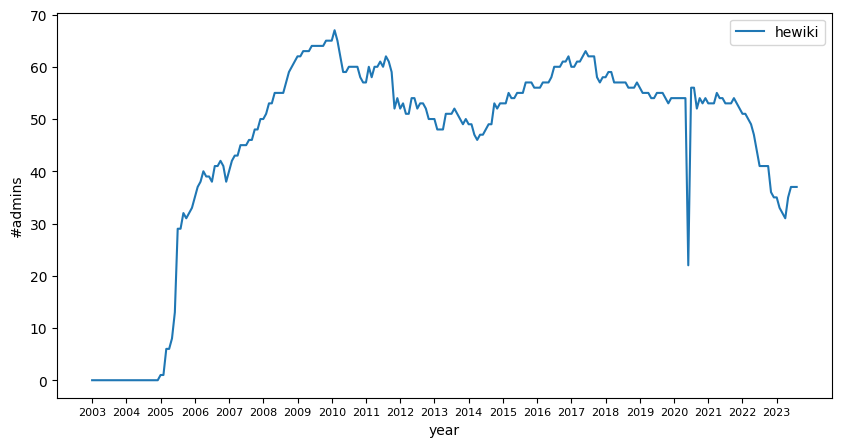

In [23]:
fig = plt.figure(figsize=(10,5))
admin_count = []
admins_wiki = admins[admins.wiki_db==wiki_db]
for i, date in enumerate(dates):
    if i+1<len(dates): 
        admin_count.append(len(admins_wiki[
            (admins_wiki.start_datetime<=datetime(date[0], date[1],1,0,0))&
            ((admins_wiki.end_datetime.isna())|(admins_wiki.end_datetime>datetime(dates[i+1][0], dates[i+1][1],1,0,0)))
        ]))
plt.plot(range(len(admin_count)), admin_count, label=wiki_db)
plt.xticks(range(0,20*12+1,12),range(2003,2024), fontsize=8)
plt.xlabel('year')
plt.ylabel('#admins')
plt.legend()
plt.show()

In [24]:
# Top days by admin drop-off
print (admins[(admins.wiki_db==wiki_db)&(admins.end_timestamp.str.startswith('2'))].end_timestamp.astype(str).replace('......$','',regex=True).value_counts().head())

20200615    34
20051216     5
20061203     4
20101124     3
20100402     3
Name: end_timestamp, dtype: int64


In [25]:
# Most common messages on admins drop-off on a specific date
specific_date = '20200615'
query = """SELECT log_timestamp, log_type, log_title, log_params, IF(comment_text LIKE '%+%' OR comment_text LIKE '%=%', comment_text,'') as comment_text
            FROM logging l JOIN comment c
            ON l.log_comment_id=c.comment_id
            WHERE log_type='rights' AND log_action='rights'
            AND (log_params LIKE '%sysop%' OR comment_text LIKE '%sysop%')
            AND log_timestamp LIKE '{specific_date}%'
            AND log_title LIKE '%@{wiki_db}'
            """.format(wiki_db=wiki_db, specific_date=specific_date)
print(wmf.mariadb.run(query,'metawiki').comment_text.value_counts())

moving to expiring rights per community consensus : https://he.wikipedia.org/w/index.php?title=%D7%95%D7%99%D7%A7%D7%99%D7%A4%D7%93%D7%99%D7%94:%D7%9E%D7%96%D7%A0%D7%95%D7%9F&diff=28427587&oldid=28427525    68
Name: comment_text, dtype: int64
